# Oxford Flowers Dataset - CNN (ResNet50)

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import seaborn as sns

### Uploading images manually

In [2]:
def load_images_from_folder(folder_path, num_images_per_class):
    data = []
    labels = []
    class_folders = os.listdir(folder_path)
    
    #All folders in the main folder and all the images in them are uploaded respectively.
    for class_folder in class_folders:
        class_folder_path = os.path.join(folder_path, class_folder)
        image_files = os.listdir(class_folder_path)
        
        #Resizing images to 224x224
        for i in range(min(num_images_per_class, len(image_files))):
            img_path = os.path.join(class_folder_path, image_files[i])
            img = Image.open(img_path)
            img = img.resize((224, 224))
            img_array = np.array(img)
            data.append(img_array)
            labels.append(class_folder)
    
    return np.array(data), np.array(labels)

In [3]:
#Number of images to retrieve from train folder for each class
num_images_per_class_train = 50  

#Number of images to retrieve from validation and test folder for each class
num_images_per_class_validation_test = 15 

dataset_path = r"C:\Users\zelih\Desktop\Data Science\Data Science Project\project"

In [4]:
#Calling load_images_from folder function for train, validation and test dataset
train_data, train_labels = load_images_from_folder(os.path.join(dataset_path, "train"), num_images_per_class_train)
validation_data, validation_labels = load_images_from_folder(os.path.join(dataset_path, "validation"), num_images_per_class_validation_test)
test_data, test_labels = load_images_from_folder(os.path.join(dataset_path, "test"), num_images_per_class_validation_test)

In [5]:
#LabelEncoder() and OneHotEncoder() operations for class labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
validation_labels_encoded = label_encoder.transform(validation_labels)
test_labels_encoded = label_encoder.transform(test_labels)

num_classes = len(label_encoder.classes_)
train_labels_one_hot = to_categorical(train_labels_encoded, num_classes)
validation_labels_one_hot = to_categorical(validation_labels_encoded, num_classes)
test_labels_one_hot = to_categorical(test_labels_encoded, num_classes)

In [6]:
#Shuffling the datasets for accurate model training
shuffle_index_train = np.random.permutation(len(train_labels))
shuffle_index_validation = np.random.permutation(len(validation_labels))
shuffle_index_test = np.random.permutation(len(test_labels))

#Updating datasets after shuffling
train_data, train_labels_one_hot = train_data[shuffle_index_train], train_labels_one_hot[shuffle_index_train]
validation_data, validation_labels_one_hot = validation_data[shuffle_index_validation], validation_labels_one_hot[shuffle_index_validation]
test_data, test_labels_one_hot = test_data[shuffle_index_test], test_labels_one_hot[shuffle_index_test]

In [7]:
#Datasets for modelling
train_generator = (train_data, train_labels_one_hot)
validation_generator = (validation_data, validation_labels_one_hot)
test_generator = (test_data, test_labels_one_hot)

### Creating ResNet50 model

In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
#Creating the ResNet model
def create_resnet_model(input_shape, num_classes):
    resnet_model = ResNet50(include_top=False, input_shape=input_shape, weights='imagenet')
    
    model = models.Sequential()
    model.add(resnet_model)
    
    #Adding a convolutional layer
    #128=number of filters, (3,3)=size of filters
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    
    #Adding a pooling layer of size (2,2)
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    #The GlobalAveragePooling layer is added.
    model.add(layers.GlobalAveragePooling2D())
    
    #Giving the one-dimensional output obtained from the convolution layers to the Artificial Neural Network (ANN).
    #512=number of neurons
    model.add(layers.Dense(512, activation='relu'))
    
    #Dropout is a regularization technique that helps reduce the model's tendency to overfit.
    #Random neurons are selected and disabled at a rate of 0.5.
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    #Output layer
    #Contains as many neurons as the number of classes. Each neuron indicates the probability that the model belongs to a class.
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [10]:
input_shape = (224, 224, 3)
num_classes = 17
resnet_model = create_resnet_model(input_shape, num_classes)

In [11]:

#Optimization algorithm specifies loss function, and evaluation metrics.
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Validation_data is used to measure performance during training.
history = resnet_model.fit(train_generator[0], train_generator[1], epochs=25, validation_data=validation_generator)

#Test_data is used to measure performance after training is finished.
test_loss, test_acc = resnet_model.evaluate(test_generator[0], test_generator[1])
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Epoch 1/25
27/27 [==============================] - 323s 11s/step - loss: 3.0930 - accuracy: 0.0706 - val_loss: 21565.1172 - val_accuracy: 0.0510
Epoch 2/25
27/27 [==============================] - 312s 12s/step - loss: 2.7136 - accuracy: 0.1553 - val_loss: 1762.1980 - val_accuracy: 0.0588
Epoch 3/25
27/27 [==============================] - 308s 11s/step - loss: 2.4992 - accuracy: 0.1847 - val_loss: 24.9939 - val_accuracy: 0.0784
Epoch 4/25
27/27 [==============================] - 292s 11s/step - loss: 2.4117 - accuracy: 0.2318 - val_loss: 2.5169 - val_accuracy: 0.1569
Epoch 5/25
27/27 [==============================] - 143s 5s/step - loss: 2.3049 - accuracy: 0.2329 - val_loss: 9.9919 - val_accuracy: 0.0667
Epoch 6/25
27/27 [==============================] - 128s 5s/step - loss: 2.1629 - accuracy: 0.2800 - val_loss: 91.0395 - val_accuracy: 0.0941
Epoch 7/25
27/27 [==============================] - 134s 5s/step - loss: 1.9073 - accuracy: 0.3753 - val_loss: 82.4651 - val_accuracy: 0.1020

### Evaluating the model

In [12]:
#Getting predictions on the test set
y_pred = resnet_model.predict(test_generator[0])
y_pred_classes = np.argmax(y_pred, axis=1)

#Getting actual labels
y_true = np.argmax(test_generator[1], axis=1)

conf_mat = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_mat)

8/8 [==============================] - 12s 1s/step
Confusion Matrix:
[[ 7  0  0  0  0  0  0  0  1  0  2  0  5  0  0  0  0]
 [ 0  2  1  0  0  0  0  0  0  0  0 10  0  0  2  0  0]
 [ 0  2  4  0  0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  1  3  1  0  0  0  1  0  0  2  4  1  0  2  0  0]
 [ 3  0  0  0  0  0  0  0  0  1  0  0  5  0  6  0  0]
 [ 0  2  0  0  0  1  0  0  0  0  0 11  0  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0  0  0  9  1  0]
 [ 0  2  3  0  0  0  0  1  0  0  0  2  0  1  6  0  0]
 [ 1  0  0  0  0  0  0  0  3  0  0  0  0  0 11  0  0]
 [ 1  1  0  0  1  3  0  0  1  0  0  0  3  0  5  0  0]
 [ 0  0  0  1  0  0  0  0  0  0 12  0  1  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  3  0  1  8  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0 11  0  0  1  1]
 [ 0  0  1  0  0  0  0  0  0  0  0  1  0  2 11  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 15  0  0]
 [ 0  3  0  0  0  1  2  0  0  1  1  3  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  3  0  8  2  1]]


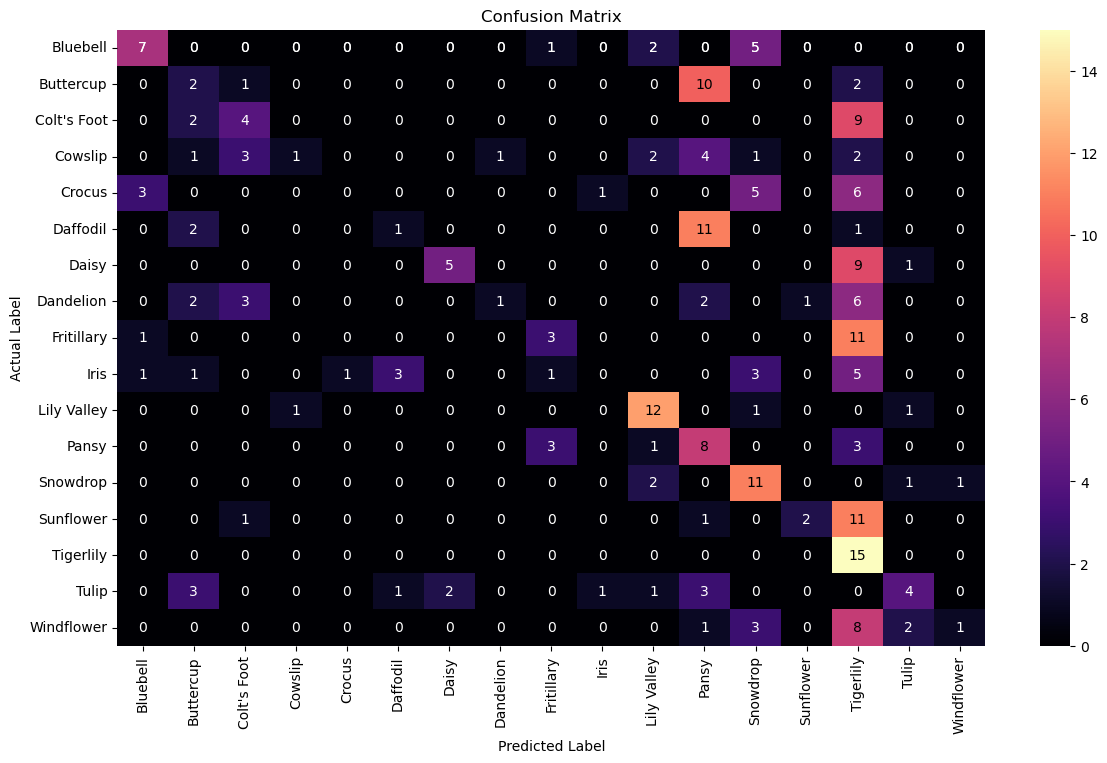

In [13]:
#Creating a Heatmap with Seaborn
class_labels = ["Bluebell", "Buttercup", "Colt's Foot", "Cowslip", "Crocus", "Daffodil", "Daisy", "Dandelion", "Fritillary", "Iris", "Lily Valley", "Pansy", "Snowdrop", "Sunflower", "Tigerlily", "Tulip", "Windflower"]
plt.figure(figsize=(14, 8))

sns.heatmap(conf_mat, annot=True, fmt="d", cmap="magma", xticklabels=class_labels, yticklabels=class_labels)

#Redefining annot parameter to show values of all classes
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j + 0.5, i + 0.5, conf_mat[i, j], ha='center', va='center', color='white' if conf_mat[i, j] < (conf_mat.max() / 2) else 'black')
        
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [14]:
class_report = classification_report(y_true, y_pred_classes)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.47      0.52        15
           1       0.15      0.13      0.14        15
           2       0.33      0.27      0.30        15
           3       0.50      0.07      0.12        15
           4       0.00      0.00      0.00        15
           5       0.20      0.07      0.10        15
           6       0.71      0.33      0.45        15
           7       0.50      0.07      0.12        15
           8       0.38      0.20      0.26        15
           9       0.00      0.00      0.00        15
          10       0.60      0.80      0.69        15
          11       0.20      0.53      0.29        15
          12       0.38      0.73      0.50        15
          13       0.67      0.13      0.22        15
          14       0.17      1.00      0.29        15
          15       0.44      0.27      0.33        15
          16       0.50      0.07      0.12        15

  

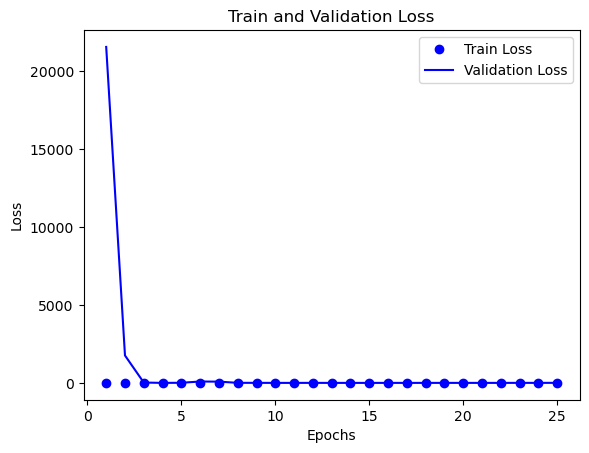

In [15]:
#Getting loss values from training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Predictions on new test data

In [16]:
#Getting predictions on the new test set
new_test_folder_path = r"C:\Users\zelih\Desktop\Data Science\Data Science Project\random_images"
num_images_per_class_new_test = 5
new_test_data, new_test_labels = load_images_from_folder(new_test_folder_path, num_images_per_class_new_test)

new_test_labels_encoded = label_encoder.transform(new_test_labels)
new_test_labels_one_hot = to_categorical(new_test_labels_encoded, num_classes)

new_test_loss, new_test_acc = resnet_model.evaluate(new_test_data, new_test_labels_one_hot)
print(f"New Test Loss: {new_test_loss}, New Test Accuracy: {new_test_acc}")

new_y_pred = resnet_model.predict(new_test_data)

new_y_pred_classes = np.argmax(new_y_pred, axis=1)
new_y_true = np.argmax(new_test_labels_one_hot, axis=1)

new_conf_mat = confusion_matrix(new_y_true, new_y_pred_classes)
print("\nNew Test Set Confusion Matrix:")
print(new_conf_mat)

3/3 [==============================] - 3s 1s/step - loss: 12.6618 - accuracy: 0.1294
New Test Loss: 12.661843299865723, New Test Accuracy: 0.12941177189350128
3/3 [==============================] - 4s 1s/step

New Test Set Confusion Matrix:
[[1 0 0 0 0 0 0 0 0 0 1 1 0 0 2 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 3 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 4 0 0]
 [1 0 0 0 0 0 0 0 0 0 3 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 4 0 0 0 1 0 0]
 [4 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0]]


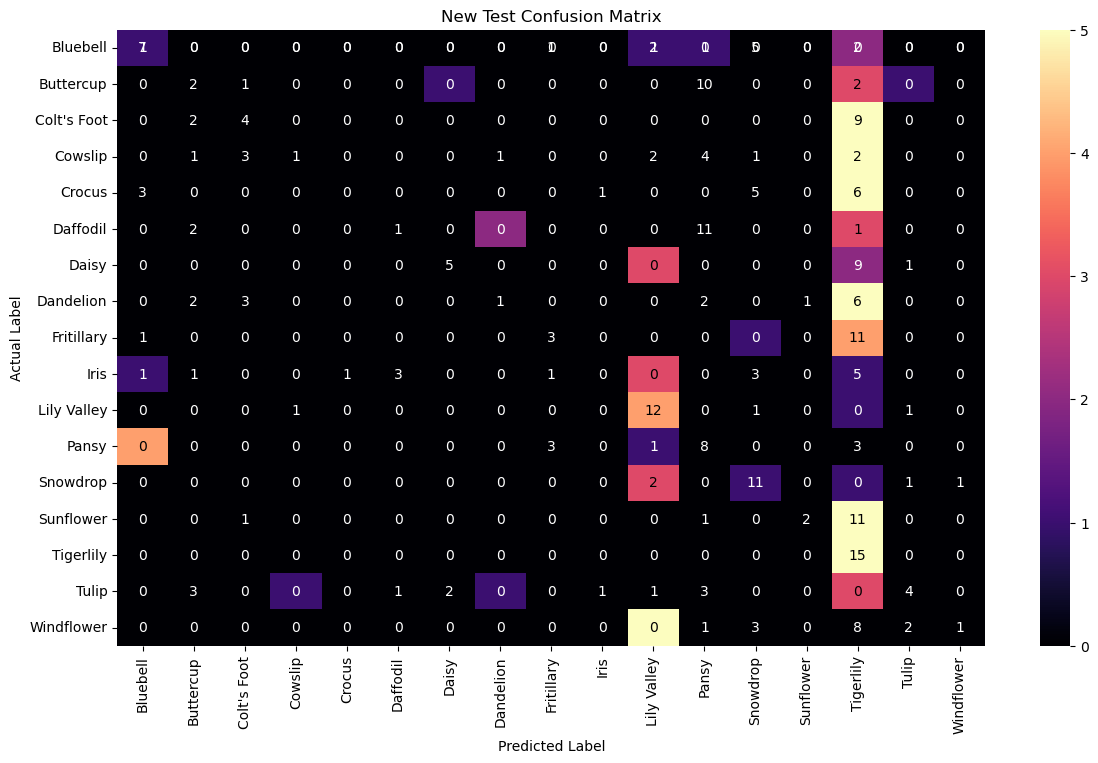

In [17]:
plt.figure(figsize=(14, 8))
sns.heatmap(new_conf_mat, annot=True, fmt="d", cmap="magma", xticklabels=class_labels, yticklabels=class_labels)

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j + 0.5, i + 0.5, conf_mat[i, j], ha='center', va='center', color='white' if new_conf_mat[i, j] < (new_conf_mat.max() / 2) else 'black')

plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("New Test Confusion Matrix")
plt.show()

In [18]:
new_class_report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_.tolist())
print("\nNew Test Classification Report:")
print(new_class_report)


New Test Classification Report:
              precision    recall  f1-score   support

    Bluebell       0.58      0.47      0.52        15
   Buttercup       0.15      0.13      0.14        15
 Colt's Foot       0.33      0.27      0.30        15
     Cowslip       0.50      0.07      0.12        15
      Crocus       0.00      0.00      0.00        15
    Daffodil       0.20      0.07      0.10        15
       Daisy       0.71      0.33      0.45        15
   Dandelion       0.50      0.07      0.12        15
  Fritillary       0.38      0.20      0.26        15
        Iris       0.00      0.00      0.00        15
 Lily Valley       0.60      0.80      0.69        15
       Pansy       0.20      0.53      0.29        15
    Snowdrop       0.38      0.73      0.50        15
   Sunflower       0.67      0.13      0.22        15
   Tigerlily       0.17      1.00      0.29        15
       Tulip       0.44      0.27      0.33        15
  Windflower       0.50      0.07      0.12     

1/1 [==============================] - 0s 99ms/step
Selected image: lily valley.jpg
Actual class: Lily Valley
Predicted class: Lily Valley (98.96%)


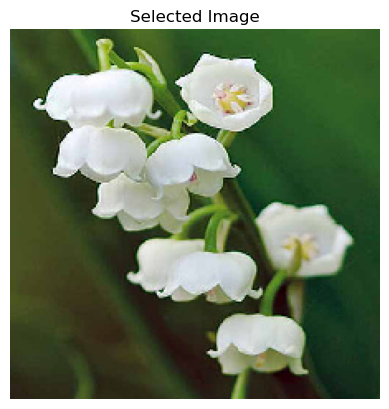

In [23]:
#Class-based prediction of a randomly selected image from new test data
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

random_images_folder = r"C:\Users\zelih\Desktop\Data Science\Data Science Project\random_images"

#Sorting class names and selecting a random class
class_names = sorted(os.listdir(random_images_folder))
random_class = random.choice(class_names)

# Folder containing images of the selected class
class_folder = os.path.join(random_images_folder, random_class)

#Getting image files in folder and selecting a random image
image_files = os.listdir(class_folder)
random_image_file = random.choice(image_files)

#Path where the selected image is located
image_path = os.path.join(class_folder, random_image_file)

#Adding image and setting its size to (224, 224)
img = image.load_img(image_path, target_size=(224, 224))

#Converting the image to a Numpy array, adding a batch size, and preprocessing the model accordingly
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

#Classifying using the model
predictions = resnet_model.predict(img_array)

#Making the classification meaningful and finding the class with the highest probability 
#Ranking them according to the probabilities between classes
decoded_predictions = [(i, class_names[i], prob) for i, prob in enumerate(predictions[0])]
decoded_predictions.sort(key=lambda x: x[2], reverse=True)

#Class information with the highest probability
class_id, predicted_class_name, probability = decoded_predictions[0]

print(f"Selected image: {random_image_file}")
print(f"Actual class: {random_class}")
print(f"Predicted class: {predicted_class_name} ({probability:.2%})")

plt.imshow(img)
plt.title("Selected Image")
plt.axis('off')
plt.show()

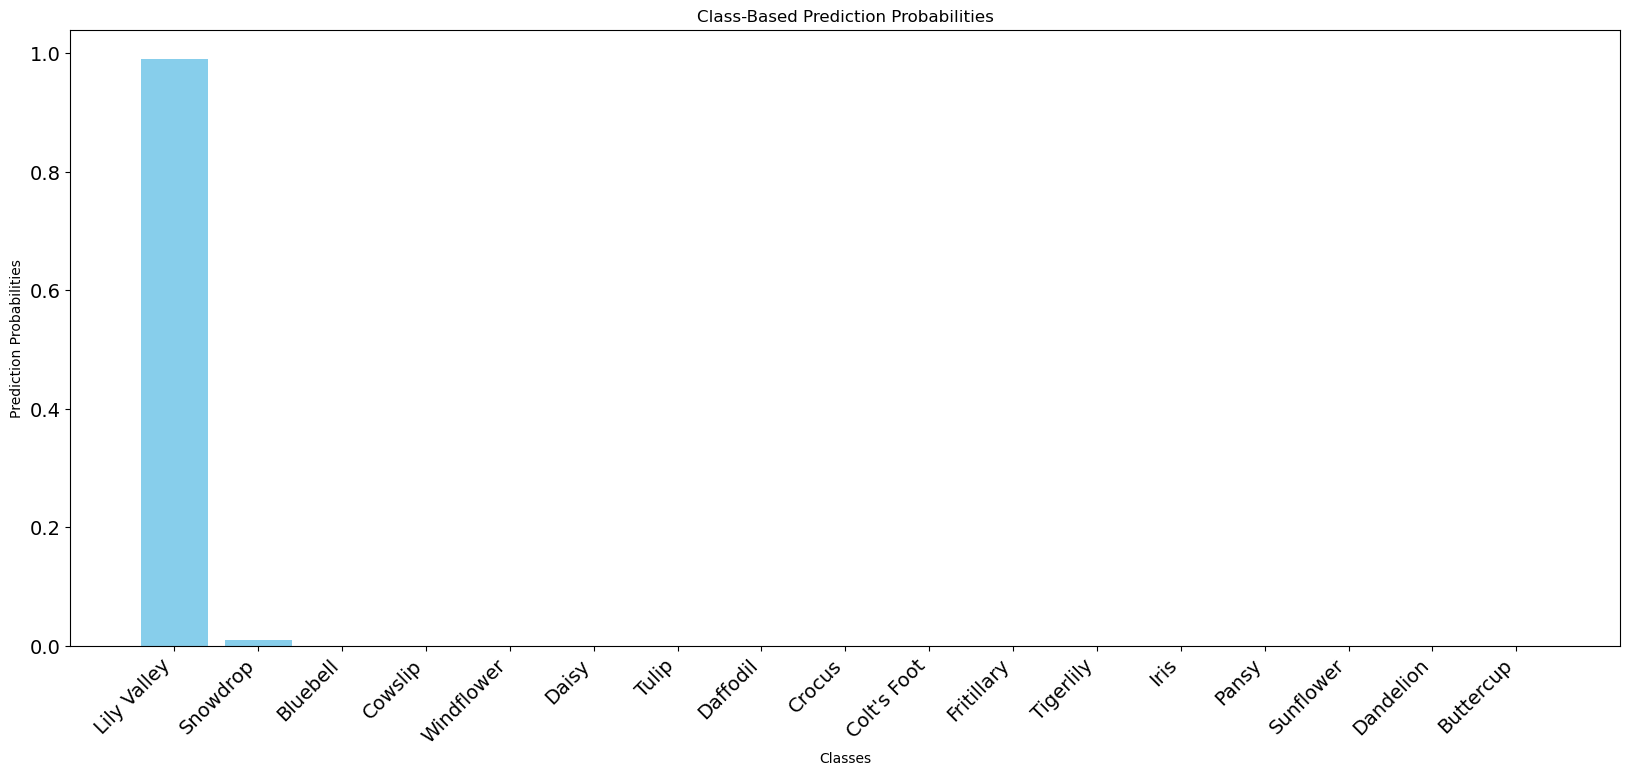

In [24]:
#Bar chart with prediction probabilities for all classes
class_names = [class_name for _, class_name, _ in decoded_predictions]
probabilities = [probability for _, _, probability in decoded_predictions]
plt.figure(figsize=(20, 8))
plt.bar(class_names, probabilities, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Prediction Probabilities')
plt.title('Class-Based Prediction Probabilities')
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()